In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

# для полнного вывода:
pd.set_option('display.max_rows',100)

# загружаем датасеты
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [2]:
# План:
#     1) Отделяем от данных "SalePrice"
#     2) Разделяем данные на численные и классовые
#     3) Анализируем количество пропуском для численных данных, заменяем пропуски медианными значениями
#     4) Столбцы с большим числом пропусков - удаляем
#     5) Анализируем классовые данные с учетом того, что в некоторых столбца NaN значения можно заменить на значение.
#     6) Объединяем численные и классовые данные
#     7) Обучаем модель алгоритмом рандомизированного леса
#     8) Проверяем результат

In [3]:
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
# отделяем результат от зависимостей 
Y_train = data.SalePrice
train = data.drop(columns=["SalePrice"])

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64


<Axes: >

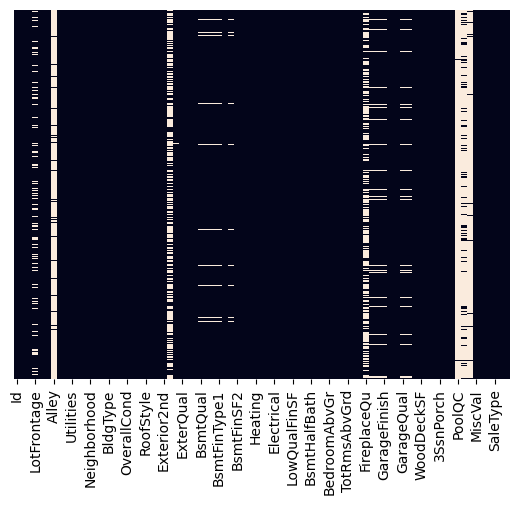

In [5]:
print(data.isna().sum().nlargest(81).head(20))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False)

In [378]:
# print(test.isna().sum().nlargest(81).head(35))
# sns.heatmap(test.isnull(), yticklabels=False, cbar=False)

In [379]:
# получаем все численные колонки
numerical_columns = [col for col in train.columns if train[col].dtype != 'object']
# получаем все классовые колонки
object_columns = [col for col in train.columns if train[col].dtype == 'object']
if len(object_columns) + len(numerical_columns) == train.shape[1]:
    print("все данные разделены")


все данные разделены


In [380]:
# функция подсчета процента пропушенных значений от общего числа
def count_missing_values(df, set='Train'):
    missing_value_counts_df = df.isnull().sum()
    missing_value_counts_df = missing_value_counts_df[missing_value_counts_df > 0].sort_values(ascending=False)
    
    # calculate percentage of missing values
    missing_value_percentage_df = round(missing_value_counts_df * 100 / len(df), 2).astype(str) + ' %'

    # concat missing count and percentage
    missing_values = pd.concat([missing_value_counts_df, missing_value_percentage_df], axis=1, keys=['Missing Values', 'Percent'])

    #missing_values = pd.DataFrame({set: missing_value_counts_df})
    return missing_values

In [381]:
print("Missing values in train and test numerical data")
print(f"Train data missing values: {train[numerical_columns].isnull().sum().sum()}")
print(f"Test data missing values: {test[numerical_columns].isnull().sum().sum()}")

Missing values in train and test numerical data
Train data missing values: 348
Test data missing values: 330


In [382]:
print("Missing Values in Train Data")
missing_value_counts = count_missing_values(train[numerical_columns])
missing_value_counts

Missing Values in Train Data


,Missing Values,Percent
LotFrontage,259,17.74 %
GarageYrBlt,81,5.55 %
MasVnrArea,8,0.55 %


In [383]:
print("Missing Values in Test Data")
missing_value_counts = count_missing_values(test[numerical_columns])
missing_value_counts

Missing Values in Test Data


,Missing Values,Percent
LotFrontage,227,15.56 %
GarageYrBlt,78,5.35 %
MasVnrArea,15,1.03 %
BsmtFullBath,2,0.14 %
BsmtHalfBath,2,0.14 %
BsmtFinSF1,1,0.07 %
BsmtFinSF2,1,0.07 %
BsmtUnfSF,1,0.07 %
TotalBsmtSF,1,0.07 %
GarageCars,1,0.07 %


In [384]:
# заполним пропущенные численые значения
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# используем значения, где недостаток данных меньше 10%
cols_with_few_missing_train = train.columns[train.isnull().sum() <= 81]
cols_with_few_missing_test = test.columns[test.isnull().sum() <= 81]

# выделяем численные колонки
numerical_cols_with_few_missing_train = train[cols_with_few_missing_train].select_dtypes(include=[np.number]).columns
numerical_cols_with_few_missing_test = test[cols_with_few_missing_test].select_dtypes(include=[np.number]).columns

# заполняем данные
numerical_imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=50, tol= 0.1)
train[numerical_cols_with_few_missing_train] = numerical_imputer.fit_transform(train[numerical_cols_with_few_missing_train])
test[numerical_cols_with_few_missing_test] = numerical_imputer.fit_transform(test[numerical_cols_with_few_missing_test])

# данные, пустые значения которых - это категория!
features_with_na = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

# удаляем излишне пустые колонки
for col in train.columns:
    if (col not in numerical_cols_with_few_missing_train and col not in features_with_na):
        train.drop(columns=[col], axis= 1 , inplace= True)
        
for col in test.columns:
    if (col not in numerical_cols_with_few_missing_train and col not in features_with_na):
        test.drop(columns=[col], axis= 1 , inplace= True)

In [385]:
# заменяем NaN на NA
for feature in features_with_na:
    train[feature].fillna('NA', inplace=True)
    test[feature].fillna('NA', inplace=True)

In [386]:
# проверяем на NaN
for col in train.columns:
    if train[col].isnull().sum() > 0:
        print(f"have Nan in {col}")

In [387]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
 
# переход из объектных к целочисленным категориальным признакам 
label_encoder = LabelEncoder()
x_categorical = train.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
x_numerical = pd.DataFrame(train.select_dtypes(include=[np.number]).values)
X = pd.concat([pd.DataFrame(x_numerical), x_categorical], axis=1).values

# # Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
 
# # Fit the regressor with x and y data
regressor.fit(X, Y_train)


RandomForestRegressor(oob_score=True, random_state=0)

In [396]:
# Evaluating the model
from sklearn.metrics import mean_squared_error, r2_score

# аналогичные преобразования для тестовой выбоки
label_encoder = LabelEncoder()
x_categorical = test.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
x_numerical = pd.DataFrame(test.select_dtypes(include=[np.number]).values)
X = pd.concat([pd.DataFrame(x_numerical), x_categorical], axis=1).values  

# Access the OOB Score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions = regressor.predict(X)

Out-of-Bag Score: 0.8567805293404076


In [397]:
# создавем scv-файл
test = pd.read_csv("test.csv")
result = pd.DataFrame({'Id': test['Id'].astype('int32'), 'SalePrice': predictions})
result.to_csv("result.csv", header=True, index=False)

In [398]:
result

,Id,SalePrice
0,1461,123240.50
1,1462,153500.75
2,1463,171696.84
3,1464,174910.82
4,1465,196335.40
...,...,...
1454,2915,83312.00
1455,2916,85827.50
1456,2917,151102.33
1457,2918,111445.93
